# Importing Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import MeanSquaredError

2024-08-08 20:38:42.335690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 20:38:42.335877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 20:38:42.493544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Defining Directories and Loading Images

In [2]:
benign_dir = "/kaggle/input/skin-lesion/new_labelled_image_data/0"
malignant_dir = "/kaggle/input/skin-lesion/new_labelled_image_data/1"
output_dir = "/kaggle/working/3_generated_images"
os.makedirs(output_dir, exist_ok=True)
image_size = (140, 140)

def load_images_from_directory(directory, target_size=image_size):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = (img / 127.5) - 1  
        images.append(img)
    return np.array(images)

benign_images = load_images_from_directory(benign_dir)
malignant_images = load_images_from_directory(malignant_dir)

# Defining Spectral Normalisation

In [3]:
class SpectralNormalization(layers.Wrapper):
    def __init__(self, layer, iteration=1, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)
        self.iteration = iteration

    def build(self, input_shape):
        if not self.layer.built:
            self.layer.build(input_shape)
        self.w = self.layer.kernel
        self.u = self.add_weight(shape=(1, self.w.shape[-1]), initializer='random_normal', trainable=False, name='sn_u')
        super(SpectralNormalization, self).build(input_shape)

    def call(self, inputs, training=None):
        self._compute_weights(training)
        return self.layer(inputs)

    def _compute_weights(self, training):
        w_shape = self.w.shape.as_list()
        w_mat = tf.reshape(self.w, [-1, w_shape[-1]])

        u = self.u
        for _ in range(self.iteration):
            v = tf.nn.l2_normalize(tf.matmul(u, w_mat, transpose_b=True))
            u = tf.nn.l2_normalize(tf.matmul(v, w_mat))
        u = tf.stop_gradient(u)
        v = tf.stop_gradient(v)
        
        sigma = tf.matmul(tf.matmul(v, w_mat), u, transpose_b=True)
        self.w.assign(self.w / sigma)
        self.u.assign(u)

def spectral_normalization(layer):
    return SpectralNormalization(layer)

# Defining Residual Block

In [4]:
def residual_block(x, filters):
    res = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, res])
    return x

# Generator

In [5]:
def build_generator():
    inputs = layers.Input(shape=(140, 140, 3))
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = residual_block(x, 64)
    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = residual_block(x, 128)
    x = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = residual_block(x, 256)
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = residual_block(x, 256)
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = residual_block(x, 128)
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = residual_block(x, 64)

    outputs = layers.Conv2D(3, (7, 7), padding='same', activation='tanh')(x)
    outputs = layers.Cropping2D(cropping=((2, 2), (2, 2)))(outputs)
    return Model(inputs, outputs)

generator = build_generator()
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 140, 140,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 70, 70,    │      3,136 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 70, 70,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 70, 70,    │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 70, 70,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 70, 70,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 70, 70,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 70, 70,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 70, 70,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │    131,200 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 35, 35,    │    147,584 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 35, 35,    │    147,584 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        512 │ conv2d_5[0][0]  

 Total params: 5,481,539 (20.91 MB)

 Trainable params: 5,476,291 (20.89 MB)

 Non-trainable params: 5,248 (20.50 KB)

# Discriminator

In [6]:
def build_discriminator():
    inputs = layers.Input(shape=(140, 140, 3))
    x = spectral_normalization(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))(inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = spectral_normalization(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = spectral_normalization(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = spectral_normalization(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1)(x)
    return Model(inputs, outputs)

discriminator = build_discriminator()
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 140, 140, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization          │ (None, 70, 70, 64)     │         3,200 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 70, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_1        │ (None, 35, 35, 128)    │       131,328 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 35, 35, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_2        │ (None, 18, 18, 256)    │       524,800 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_3        │ (None, 9, 9, 512)      │     2,098,176 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 9, 9, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        41,473 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,802,561 (10.69 MB)

 Trainable params: 2,799,809 (10.68 MB)

 Non-trainable params: 2,752 (10.75 KB)

# Defining VGG19 for Perceptual Loss

In [7]:
def build_perceptual_model():
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(140, 140, 3))
    vgg.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    return model

mse = MeanSquaredError()
perceptual_model = build_perceptual_model()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Perceptual Loss

In [8]:
def perceptual_loss(y_true, y_pred):
    y_true = (y_true + 1) * 127.5
    y_pred = (y_pred + 1) * 127.5
    return mse(perceptual_model(y_true), perceptual_model(y_pred))

# Wasserstein Loss

In [9]:

def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

# Gradient Penalty

In [10]:
def gradient_penalty(real_images, fake_images, discriminator):
    batch_size = tf.shape(real_images)[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_images + (1 - alpha) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    grads = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return gradient_penalty

# WGAN

In [11]:
class WGAN(Model):
    def __init__(self, generator, discriminator, gp_weight=10.0):
        super(WGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gp_weight = gp_weight
    
    def compile(self, gen_optimizer, disc_optimizer, gen_loss_fn, disc_loss_fn, perceptual_loss_fn):
        super(WGAN, self).compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.perceptual_loss_fn = perceptual_loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Train discriminator
        for _ in range(2):  # Train the discriminator twice per generator step
            random_latent_vectors = tf.random.normal(shape=(batch_size, 140, 140, 3))
            fake_images = self.generator(random_latent_vectors)

            with tf.GradientTape() as tape:
                real_preds = self.discriminator(real_images, training=True)
                fake_preds = self.discriminator(fake_images, training=True)
                d_loss = tf.reduce_mean(fake_preds) - tf.reduce_mean(real_preds)
                gp = gradient_penalty(real_images, fake_images, self.discriminator)
                d_loss += self.gp_weight * gp
            
            d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.disc_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # Train generator
        misleading_labels = -tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_preds = self.discriminator(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_preds)
            p_loss = self.perceptual_loss_fn(real_images, fake_images)
            total_g_loss = g_loss + p_loss
        
        g_grads = tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": total_g_loss}

# Further lower learning rates
gen_optimizer = Adam(5e-6, beta_1=0.5)
disc_optimizer = Adam(5e-6, beta_1=0.5)

# Model Training

In [12]:
wgan = WGAN(generator, discriminator)

wgan.compile(
    gen_optimizer=gen_optimizer,
    disc_optimizer=disc_optimizer,
    gen_loss_fn=wasserstein_loss,
    disc_loss_fn=wasserstein_loss,
    perceptual_loss_fn=perceptual_loss
)

# Train the WGAN
wgan.fit(malignant_images, epochs=150, batch_size=64)

Epoch 1/150


2024-08-08 20:43:08.352279: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng1{k2=2,k3=0} for conv (f32[3,64,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,144,144]{3,2,1,0}, f32[64,3,144,144]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-08 20:43:08.574028: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.221934367s
Trying algorithm eng1{k2=2,k3=0} for conv (f32[3,64,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,144,144]{3,2,1,0}, f32[64,3,144,144]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-08 20:43:13.21744

7/7 ━━━━━━━━━━━━━━━━━━━━ 285s 13s/step - d_loss: 1372.0082 - g_loss: 25.8255
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - d_loss: 646.9099 - g_loss: 23.7903
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - d_loss: 471.9597 - g_loss: 21.7476
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - d_loss: 457.2156 - g_loss: 20.4756
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - d_loss: 267.4865 - g_loss: 20.1247
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - d_loss: 237.5146 - g_loss: 18.5806
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - d_loss: 244.8921 - g_loss: 18.2331
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - d_loss: 171.6330 - g_loss: 17.3381
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - d_loss: 146.2991 - g_loss: 17.3885
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - d_loss: 147.9141 - g_loss: 15.9659
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - d_loss: 78.0967 - g_loss: 15.7978
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - d_loss: 61

# Generate and Saving Images

In [13]:
def generate_and_save_images(model, output_dir, num_images=5000):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i in range(num_images):
        random_latent_vector = tf.random.normal(shape=(1, 140, 140, 3))
        generated_image = model.generator(random_latent_vector)
        generated_image = (generated_image[0] + 1) * 127.5
        generated_image = tf.keras.preprocessing.image.array_to_img(generated_image)
        generated_image.save(os.path.join(output_dir, f"generated_image_{i}.png"))

generate_and_save_images(wgan, output_dir, num_images=1000)

# Display Generated vs Original Image

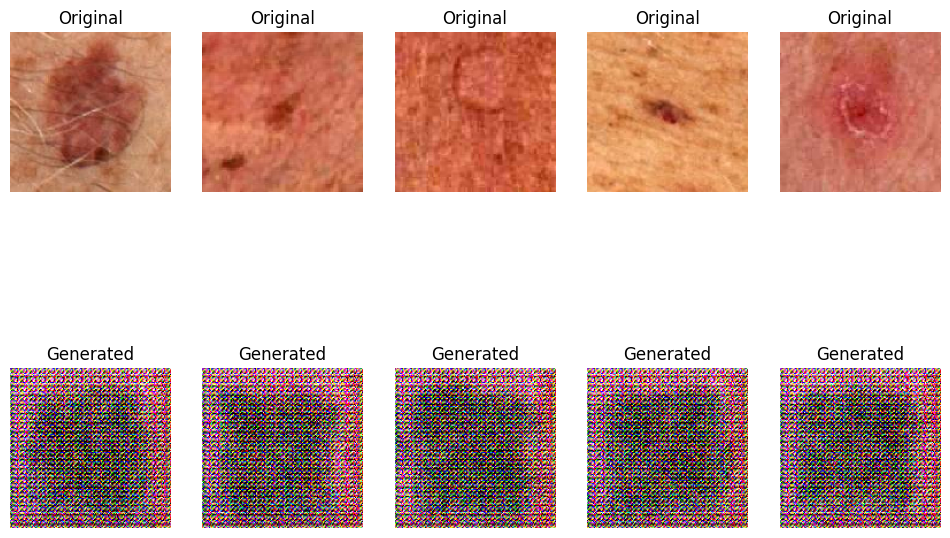

In [14]:
def display_images(generator, original_images, num_images=5):
    generated_images = []
    for _ in range(num_images):
        random_latent_vector = tf.random.normal(shape=(1, 140, 140, 3))
        generated_image = generator(random_latent_vector)
        generated_image = (generated_image[0] + 1) * 127.5  
        generated_image = tf.keras.preprocessing.image.array_to_img(generated_image)
        generated_images.append(generated_image)

    original_images = (original_images[:num_images] + 1) * 127.5  
    original_images = [tf.keras.preprocessing.image.array_to_img(img) for img in original_images]
    plt.figure(figsize=(12, 8))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.axis('off')
        plt.title("Original")
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.title("Generated")
    plt.show()
display_images(generator, malignant_images, num_images=5)
